In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 1. load data

In [2]:
dataset_name = 'news'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [item['article'] for item in train_dataset]
    train_highlights = [item['highlights'] for item in train_dataset]
    val_articles = [item['article'] for item in val_dataset]
    val_highlights = [item['highlights'] for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 652 ms, sys: 48 ms, total: 700 ms
Wall time: 699 ms


### 2. sentencepiece model

In [4]:
train_new_model = False

In [5]:
%%time
if train_new_model:
    with open('data/news_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                                   model_prefix='news10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


### 3. dataset and dataloaders

In [6]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/news{int(vocab_size/1000)}k.model'

In [7]:
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [8]:
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [9]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([100, 128])
torch.Size([21, 128])


### 4. model architecture

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [11]:
writer = SummaryWriter()

In [12]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)

### 5. generator pretraining

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 1e-3
opt = torch.optim.Adam(G.parameters(), lr=lr)
n_epochs = 40

epoch_losses = []
val_losses = []
iter_num = -1

In [16]:
for epoch_idx in range(n_epochs):
    G.train()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(train_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        opt.zero_grad()
        out = G(article, highlight, teacher_forcing_ratio=0.2)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1)
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset))
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    
    indices = sps.randint(0, out.size(1)).rvs(size=3)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        print(f'predicted: {pred}')
        print(f'truth: {truth}')

539it [01:22,  6.56it/s]
2it [00:00, 17.18it/s]

epoch 0 train loss: 6.920704888466759


231it [00:13, 17.22it/s]


epoch 0 val loss: 6.798401571265857


1it [00:00,  5.92it/s]

predicted: i ssssssssss
truth: how does the world s smallest computer work
predicted: i sssssssss
truth: suffering for no fault driver who let langur control steering
predicted: i ssssssssss
truth: french singer barbara weldens dies on stage during concert


539it [01:22,  6.53it/s]
2it [00:00, 17.17it/s]

epoch 1 train loss: 6.5917339519895055


231it [00:13, 17.19it/s]


epoch 1 val loss: 6.471848298482409


1it [00:00,  6.11it/s]

predicted: i tsssssss
truth: akmal should be ashamed for being sent back to pak waqar
predicted: video sssssssss
truth: event guests sing you ll never walk alone over terror threat
predicted: i sssss on a on
truth: first look poster of sushant kriti s raabta unveiled


539it [01:23,  6.49it/s]
2it [00:00, 16.89it/s]

epoch 2 train loss: 6.2167205008618645


231it [00:13, 17.02it/s]


epoch 2 val loss: 6.173767250076283


1it [00:00,  6.27it/s]

predicted: woman womanssssssss
truth: us woman severely injured after mistaking dynamite for candle
predicted: ukssedededed in in
truth: 22 year old model shot dead inside her porsche in iraq
predicted: 4 yr old killed in in in in in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir


539it [01:23,  6.43it/s]
2it [00:00, 16.29it/s]

epoch 3 train loss: 5.870435153150392


231it [00:13, 16.89it/s]


epoch 3 val loss: 5.902640901200312


1it [00:00,  5.64it/s]

predicted: ronaldo ssst to to to to to to in in
truth: brendon mccullum hit test cricket s fastest ton in his last match
predicted: india sss in in in in in in
truth: match s pre lunch session extended as food stuck in b luru traffic
predicted: first look of s s s s s s s s s
truth: first look poster of sushant kriti s raabta unveiled


539it [01:23,  6.44it/s]
2it [00:00, 16.22it/s]

epoch 4 train loss: 5.562689922634041


231it [00:13, 16.79it/s]


epoch 4 val loss: 5.710728362220311


1it [00:00,  6.15it/s]

predicted: i to to to to to to sanjay on ranb on ranb
truth: would like to work with ranbir kapoor again rajkumar hirani
predicted: s pm pmsss s s s pm s pm
truth: georgia pm kvirikashvili resigns amid rift with ruling party
predicted: i ted to to india india india india india
truth: air india refuses to let wheelchair bound passenger on plane


539it [01:24,  6.39it/s]
2it [00:00, 15.90it/s]

epoch 5 train loss: 5.315366246337536


231it [00:13, 16.73it/s]


epoch 5 val loss: 5.589607311164916


1it [00:00,  5.43it/s]

predicted: girleded to to toed fored yr old girl
truth: was threatened to change asaram rape victim s age principal
predicted: 2 missiless from afghanistan in ins
truth: 4 missiles fired into pakistan from afghanistan
predicted: real madrid 1 1 1 to 1 1 to 1s
truth: barcelona become world s 1st team to spend 500 million on wages


539it [01:24,  6.37it/s]
2it [00:00, 16.50it/s]

epoch 6 train loss: 5.105050813473337


231it [00:13, 16.70it/s]


epoch 6 val loss: 5.475764910730016


1it [00:00,  5.29it/s]

predicted: delhi delhi hcss hc against hc case case case
truth: delhi cm discharged in defamation case over thulla remark
predicted: first look poster ofshantshantshant su raab raab raab raab unveiled
truth: first look poster of sushant kriti s raabta unveiled
predicted: bengaluru startup startups raises raise raisess million
truth: car rental startup zoomcar raises 40 million in series c


539it [01:24,  6.37it/s]
2it [00:00, 15.63it/s]

epoch 7 train loss: 4.925087566907398


231it [00:13, 16.64it/s]


epoch 7 val loss: 5.4185473448474015


1it [00:00,  5.36it/s]

predicted: us was to tossssss s s
truth: csk pacer lungi reveals he used to sell peanuts on roadside
predicted: amazon to test test for fors at in in in london
truth: amazon to test one hour delivery for fashion show clothes
predicted: amazon to test test for fors at in in in london
truth: amazon to test one hour delivery for fashion show clothes


539it [01:25,  6.34it/s]
2it [00:00, 16.53it/s]

epoch 8 train loss: 4.775247917219598


231it [00:13, 16.70it/s]


epoch 8 val loss: 5.391190543261483


1it [00:00,  5.81it/s]

predicted: congress congress congress to to to for for for for for polls
truth: cong ncp join hands against bjp for maha council by poll
predicted: scientistsssssssss
truth: online volunteers help find star that exploded 97 cr yrs ago
predicted: 4 missiles fired  afghanistan afghanistan pakistan
truth: 4 missiles fired into pakistan from afghanistan


539it [01:24,  6.36it/s]
2it [00:00, 16.14it/s]

epoch 9 train loss: 4.632962130724899


231it [00:13, 16.59it/s]


epoch 9 val loss: 5.375479635509556


1it [00:00,  5.85it/s]

predicted: amazon pays tax taxe taxes taxes trump trump
truth: amazon must pay real costs and taxes now donald trump
predicted: delhi court courtss kejriwal defamation case case
truth: delhi cm discharged in defamation case over thulla remark
predicted: man creates robot from  car carss
truth: man turns his car into a drivable hot tub


539it [01:24,  6.37it/s]
2it [00:00, 15.89it/s]

epoch 10 train loss: 4.504246973354504


231it [00:13, 16.59it/s]


epoch 10 val loss: 5.367743621427012


1it [00:00,  5.76it/s]

predicted: badlyedssssennss
truth: game of thrones puts women at the forefront gwendoline
predicted: us investigators dead dead dead gun gun in in in
truth: 22 year old model shot dead inside her porsche in iraq
predicted: thievesss into into house into house in atm
truth: us thieves try to steal tv return it as it didn t fit in car


539it [01:24,  6.40it/s]
2it [00:00, 16.39it/s]

epoch 11 train loss: 4.3901609498310865


231it [00:13, 16.51it/s]


epoch 11 val loss: 5.35157104696807


1it [00:00,  6.02it/s]

predicted: maha govtss for for for for for for fors
truth: rahul given notice over nude dalit kids being beaten up video
predicted: man gets 8 8 8 8 after after collides beer
truth: us man awarded 4 8 crore after beer burns his organs
predicted: un agency attacksssss attacks
truth: enough evidence to convict syrian prez of war crimes un


539it [01:24,  6.38it/s]
2it [00:00, 16.04it/s]

epoch 12 train loss: 4.286974481146233


231it [00:13, 16.62it/s]


epoch 12 val loss: 5.363123917368861


1it [00:00,  5.69it/s]

predicted: man climbs 30 foot unoleole in to to to to fianc e
truth: man climbs 30 feet ghaziabad hoarding to win back ex fianc e
predicted: solar solar solar solared to earth earth
truth: minor solar flare expected to hit earth today cause auroras
predicted: teen trieds toself after afteringss in 3 days
truth: scolded for using phone mumbai teen hangs self dies in hospital


539it [01:24,  6.40it/s]
2it [00:00, 16.02it/s]

epoch 13 train loss: 4.184731083049176


231it [00:13, 16.60it/s]


epoch 13 val loss: 5.36077761389223


1it [00:00,  6.28it/s]

predicted: cong congress congress joins to to for for for for
truth: cong ncp join hands against bjp for maha council by poll
predicted: iit roorkee test floating float water water water water water
truth: iit roorkee tests device to generate electricity from river flow
predicted: srikanth srikanth conferred padma shri s s highest sports
truth: kidambi srikanth conferred with padma shri award


539it [01:24,  6.37it/s]
2it [00:00, 16.04it/s]

epoch 14 train loss: 4.103167254418031


231it [00:13, 16.63it/s]


epoch 14 val loss: 5.353709710823044


1it [00:00,  6.18it/s]

predicted: iit roorkee float floating machine water water water water water
truth: iit roorkee tests device to generate electricity from river flow
predicted: kartarpur corridorpurpurpurpur on kartarpur pm
truth: kartarpur corridor atonement for mistake made in 1947 pm modi
predicted: kerala schoolss free to to forss
truth: village issues marriage certificate only after green wedding


539it [01:24,  6.35it/s]
2it [00:00, 16.40it/s]

epoch 15 train loss: 4.008057520641544


231it [00:13, 16.61it/s]


epoch 15 val loss: 5.3759385899417484


1it [00:00,  5.83it/s]

predicted: mccullum hits test fastestnn inn inn inn
truth: brendon mccullum hit test cricket s fastest ton in his last match
predicted: daughter daughters t be t  on on ex cm cm cm cm
truth: daughters should be taught about good bad touch mp cm
predicted: srikanth sed padma padma padma shri s highest sports
truth: kidambi srikanth conferred with padma shri award


539it [01:24,  6.40it/s]
2it [00:00, 16.13it/s]

epoch 16 train loss: 3.931763471875872


231it [00:13, 16.59it/s]


epoch 16 val loss: 5.382486789434333


1it [00:00,  5.79it/s]

predicted: srikanth srikanthed padma shri shri shri s sth highest civilian
truth: kidambi srikanth conferred with padma shri award
predicted: amazon test test 1 000 delivery for items in show
truth: amazon to test one hour delivery for fashion show clothes
predicted: woman founds after after after after malfunction malfunction malfunction
truth: us woman severely injured after mistaking dynamite for candle


539it [01:23,  6.43it/s]
2it [00:00, 16.49it/s]

epoch 17 train loss: 3.860857804173238


231it [00:13, 16.64it/s]


epoch 17 val loss: 5.379876385447108


1it [00:00,  6.26it/s]

predicted: bus driverss foringing with bus bus bus bus bus bus
truth: suffering for no fault driver who let langur control steering
predicted: iit roorkee float floating electricit water water water water water
truth: iit roorkee tests device to generate electricity from river flow
predicted: georgia s pmvivivi resignss with party s
truth: georgia pm kvirikashvili resigns amid rift with ruling party


539it [01:24,  6.39it/s]
2it [00:00, 16.02it/s]

epoch 18 train loss: 3.7921873315286136


231it [00:13, 16.61it/s]


epoch 18 val loss: 5.400140938633346


1it [00:00,  5.54it/s]

predicted: bengalur luru police police uses challenge withoutoutout helmet
truth: b luru police ask people to wear helmets share 10 secs challenge
predicted: first look poster of sushant kriti kriti starrer raab raab out
truth: first look poster of sushant kriti s raabta unveiled
predicted: shoaib will become asian asian under world cup wc pak
truth: pak will become asian tiger under imran khan shoaib akhtar


539it [01:24,  6.39it/s]
2it [00:00, 16.58it/s]

epoch 19 train loss: 3.7259351009275856


231it [00:13, 16.60it/s]


epoch 19 val loss: 5.4323150231373765


1it [00:00,  6.02it/s]

predicted: used pe pe pess with hiss 22 yr old rashid kumar
truth: csk pacer lungi reveals he used to sell peanuts on roadside
predicted: facebook askss to to sharesssss report
truth: facebook asks us banks for users financial data report
predicted: mccullum hits test test faste fastest century century in his his
truth: brendon mccullum hit test cricket s fastest ton in his last match


33it [00:05,  6.10it/s]


KeyboardInterrupt: 

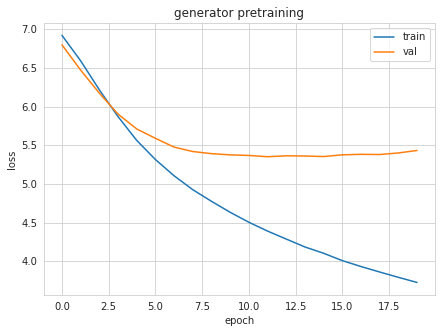

In [17]:
plt.figure(figsize=(7, 5))
plt.title('generator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [18]:
save_path = 'saved_models/pretrained_seq2seq_gen_2.pth'
torch.save(G.state_dict(), save_path)

### 6. discriminator pretraining

In [39]:
save_path = 'saved_models/pretrained_seq2seq_gen_2.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [40]:
G.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [41]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)

In [42]:
criterion = nn.BCELoss()
lr = 0.01
opt = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 3

epoch_losses = []
val_losses = []
iter_num = -1
writer = SummaryWriter()

In [43]:
for epoch_idx in range(n_epochs):
    D.train()
    total_loss = 0.
    
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        opt.zero_grad()
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    D.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        total_loss += loss.data.item() * article.size(1) * 2

    val_losses.append(total_loss / len(val_dataset) / 2)
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [00:44, 12.18it/s]
2it [00:00, 13.37it/s]

epoch 0 train loss: 0.006495680388792783


231it [00:16, 14.05it/s]
2it [00:00, 12.45it/s]

epoch 0 val loss: 8.763491667604195e-06


539it [00:44, 12.18it/s]
2it [00:00, 13.22it/s]

epoch 1 train loss: 0.0013468640580979912


231it [00:16, 14.05it/s]
2it [00:00, 12.08it/s]

epoch 1 val loss: 7.909138568003998e-06


539it [00:44, 12.21it/s]
2it [00:00, 13.97it/s]

epoch 2 train loss: 0.001158142228011312


231it [00:16, 14.02it/s]

epoch 2 val loss: 7.03465493455684e-06


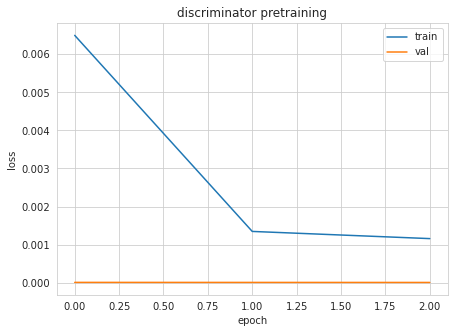

In [45]:
plt.figure(figsize=(7, 5))
plt.title('discriminator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [46]:
save_path = 'saved_models/pretrained_dis2.pth'
torch.save(D.state_dict(), save_path)

### 7. adversarial training

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
vocab_size = 10000
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/pretrained_seq2seq_gen_2.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [12]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/pretrained_dis2.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [13]:
n_epochs = 30

In [14]:
writer = SummaryWriter()

In [15]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [16]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rewards = D(generated_highlight).squeeze(1)
        rewards = 1 - rewards
        writer.add_scalar('Reward/train', rewards.mean().data.item(), iter_num)
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        pg_loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss/gen_pg_train', pg_loss.data.item(), iter_num)
        total_G_loss += pg_loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    total_reward = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rewards = D(generated_highlight).squeeze(1)
        rewards = 1 - rewards
        total_reward += rewards.mean().data.item() * article.size(1)
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        total_loss += pg_loss.data.item() * article.size(1)
    writer.add_scalar('Reward/val', total_reward / len(val_dataset), iter_num)
    writer.add_scalar('Loss/gen_pg_val', total_loss / len(val_dataset), iter_num)
    
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    ind = sps.randint(0, out.size(1)).rvs(size=1)[0]
    print(f'predicted: {tensor_to_text(out, sp)[ind]}')
    print(f'truth: {tensor_to_text(highlight, sp)[ind]}')

539it [02:38,  3.41it/s]
1it [00:00,  9.35it/s]

epoch 0 G loss: 77.43548095118294
epoch 0 D loss: 0.0020103126721064267


231it [00:26,  8.76it/s]
231it [00:13, 16.79it/s]
0it [00:00, ?it/s]

epoch 0 val loss: 5.507088435382274
predicted: mccullum hit test test test fastest fastest century in in
truth: brendon mccullum hit test cricket s fastest ton in his last match


539it [02:40,  3.37it/s]
1it [00:00,  8.96it/s]

epoch 1 G loss: 59.579481874968806
epoch 1 D loss: 0.001413064664866587


231it [00:26,  8.71it/s]
231it [00:13, 16.69it/s]
0it [00:00, ?it/s]

epoch 1 val loss: 5.466915893286556
predicted: armyables against soldiers soldiers soldiers soldierss army
truth: soldiers to face action for disrespecting militants bodies


539it [02:40,  3.36it/s]
1it [00:00,  9.24it/s]

epoch 2 G loss: 58.03775519394293
epoch 2 D loss: 0.0023342771037848415


231it [00:26,  8.67it/s]
231it [00:13, 16.72it/s]
0it [00:00, ?it/s]

epoch 2 val loss: 5.477511858892474
predicted: facebook askss to to sharessss report
truth: facebook asks us banks for users financial data report


539it [02:41,  3.34it/s]
1it [00:00,  9.16it/s]

epoch 3 G loss: 57.17311521523506
epoch 3 D loss: 0.0017639699444481963


231it [00:26,  8.63it/s]
231it [00:13, 16.58it/s]
0it [00:00, ?it/s]

epoch 3 val loss: 5.485075882491427
predicted: georgia s pm svivivi pm minister minister minister minister
truth: georgia pm kvirikashvili resigns amid rift with ruling party


539it [02:41,  3.33it/s]
1it [00:00,  8.68it/s]

epoch 4 G loss: 56.556800328342206
epoch 4 D loss: 0.002315736688475009


231it [00:26,  8.59it/s]
231it [00:13, 16.62it/s]
0it [00:00, ?it/s]

epoch 4 val loss: 5.494916665740204
predicted: ferrari s driver crashes car car car car car car car
truth: f1 driver crashes after race ends rides back on another car


539it [02:43,  3.31it/s]
1it [00:00,  9.20it/s]

epoch 5 G loss: 56.07752315862392
epoch 5 D loss: 0.002061691134126963


231it [00:26,  8.61it/s]
231it [00:13, 16.66it/s]
0it [00:00, ?it/s]

epoch 5 val loss: 5.490120306089639
predicted: never never  what what should have have different differently in film
truth: i never think about what i should ve done differently kajol


446it [02:14,  3.31it/s]


KeyboardInterrupt: 

In [56]:
save_path = 'saved_models/dis2_adv.pth'
torch.save(D.state_dict(), save_path)

save_path = 'saved_models/gen2_adv.pth'
torch.save(G.state_dict(), save_path)